***Note: this is the CyclicFlowModulation.ipynb notebook. The
PDF version "Cyclic Flow Modulation"
is available [here](CyclicFlowModulation.pdf).***

# Introduction
The reaction 
\ch{F6P + ATP <>[PFK] F16P + ADP}
catalysed by the enzyme PFK is a key step in glycolysis where:

- \ch{PFK} phosphofructokinase 
- \ch{F6P} fructose-6-phosphate
- \ch{F16P} fructose-1,6-biphosphate

As pointed out by 
<cite data-cite="Cor12">Cornish-Bowden (2012)</cite>, section 12.1.1., the PFK-catalysed reaction forms a cycle with the reaction:
\ch{F16P + H2O <>[FBP] F6P + Pi}
where:

- \ch{FBP} fructose biphosphatase
- \ch{Pi} inorganic phosphate

This cycle is *modulated* by a number of species which simultaneously activate the PFK reaction and inhibit the FBP reaction or *vice-versa*.  
<cite data-cite="Cor12">Cornish-Bowden (2012)</cite> [section 12.1.1],
<cite data-cite="GarGri17">Garret and Grisham (2017)</cite> [sections 18.3c,22.1 (3), 22.2a]. Indeed <cite data-cite="GarGri17">Garret and Grisham (2017)</cite> [section 22.2b] explicitly states that "substrate cycles provide metabolic control mechanisms".

The species which activate PFK and inhibit FBP include:

- \ch{AMP}
- \ch{F26P} fructose-2,6-phosphate

The species which inhibit PFK and activate FBP include:

- ATP
- \ch{Cit} citrate

Because of the cyclic nature of these two reactions, and the fact that flow is modulated, the term  **Cyclic Flow Modulation** (CFM) is used to decribe such reaction systems.

- This note gives a bond graph <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> interpretation of such Cyclic Flow Modulation and uses  [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X">(Cudmore et. al., 2019)</cite> to build an analyse a simple example of Cyclic Flow Modulation.

- The note also provides an example of graphical computational modularity where graphical representions in SVG format are converted using svgBondGraph -- see Tutorial [svgBondGraph](svgBondGraph.ipynb)

- Cooperativity is discussed in the notebook [Cooperativity](Cooperativity.ipynb) and modulated cooperativity is discussed in the notebook [modulated Cooperativity](modulatedCooperativity.ipynb).

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modular bond graphs
import modularBondGraph as mbg

## Data structure copy
import copy

## For reimporting: use imp.reload(module)
import importlib as imp

## Set quiet=False for verbose output
quiet = True

# Modulated Cooperative Enzyme-catalysed Reaction (mECR)

As discussed in the notebook notebook [modulatedCooperativity](modulatedCooperativity.ipynb) a modulated Cooperative Enzyme-catalysed Reaction may be modelled using the following bond graph. Two instances of this model are used in the sequel to model Cyclic Flow Modulation.

## Two-stage cooperative enzyme-catalysed reaction (N=2) with modulation<a id='coop2'></a>
The cooperative enzyme-catalysed reaction is modulated by the activation species (Act) and the inhibition species (Inh).

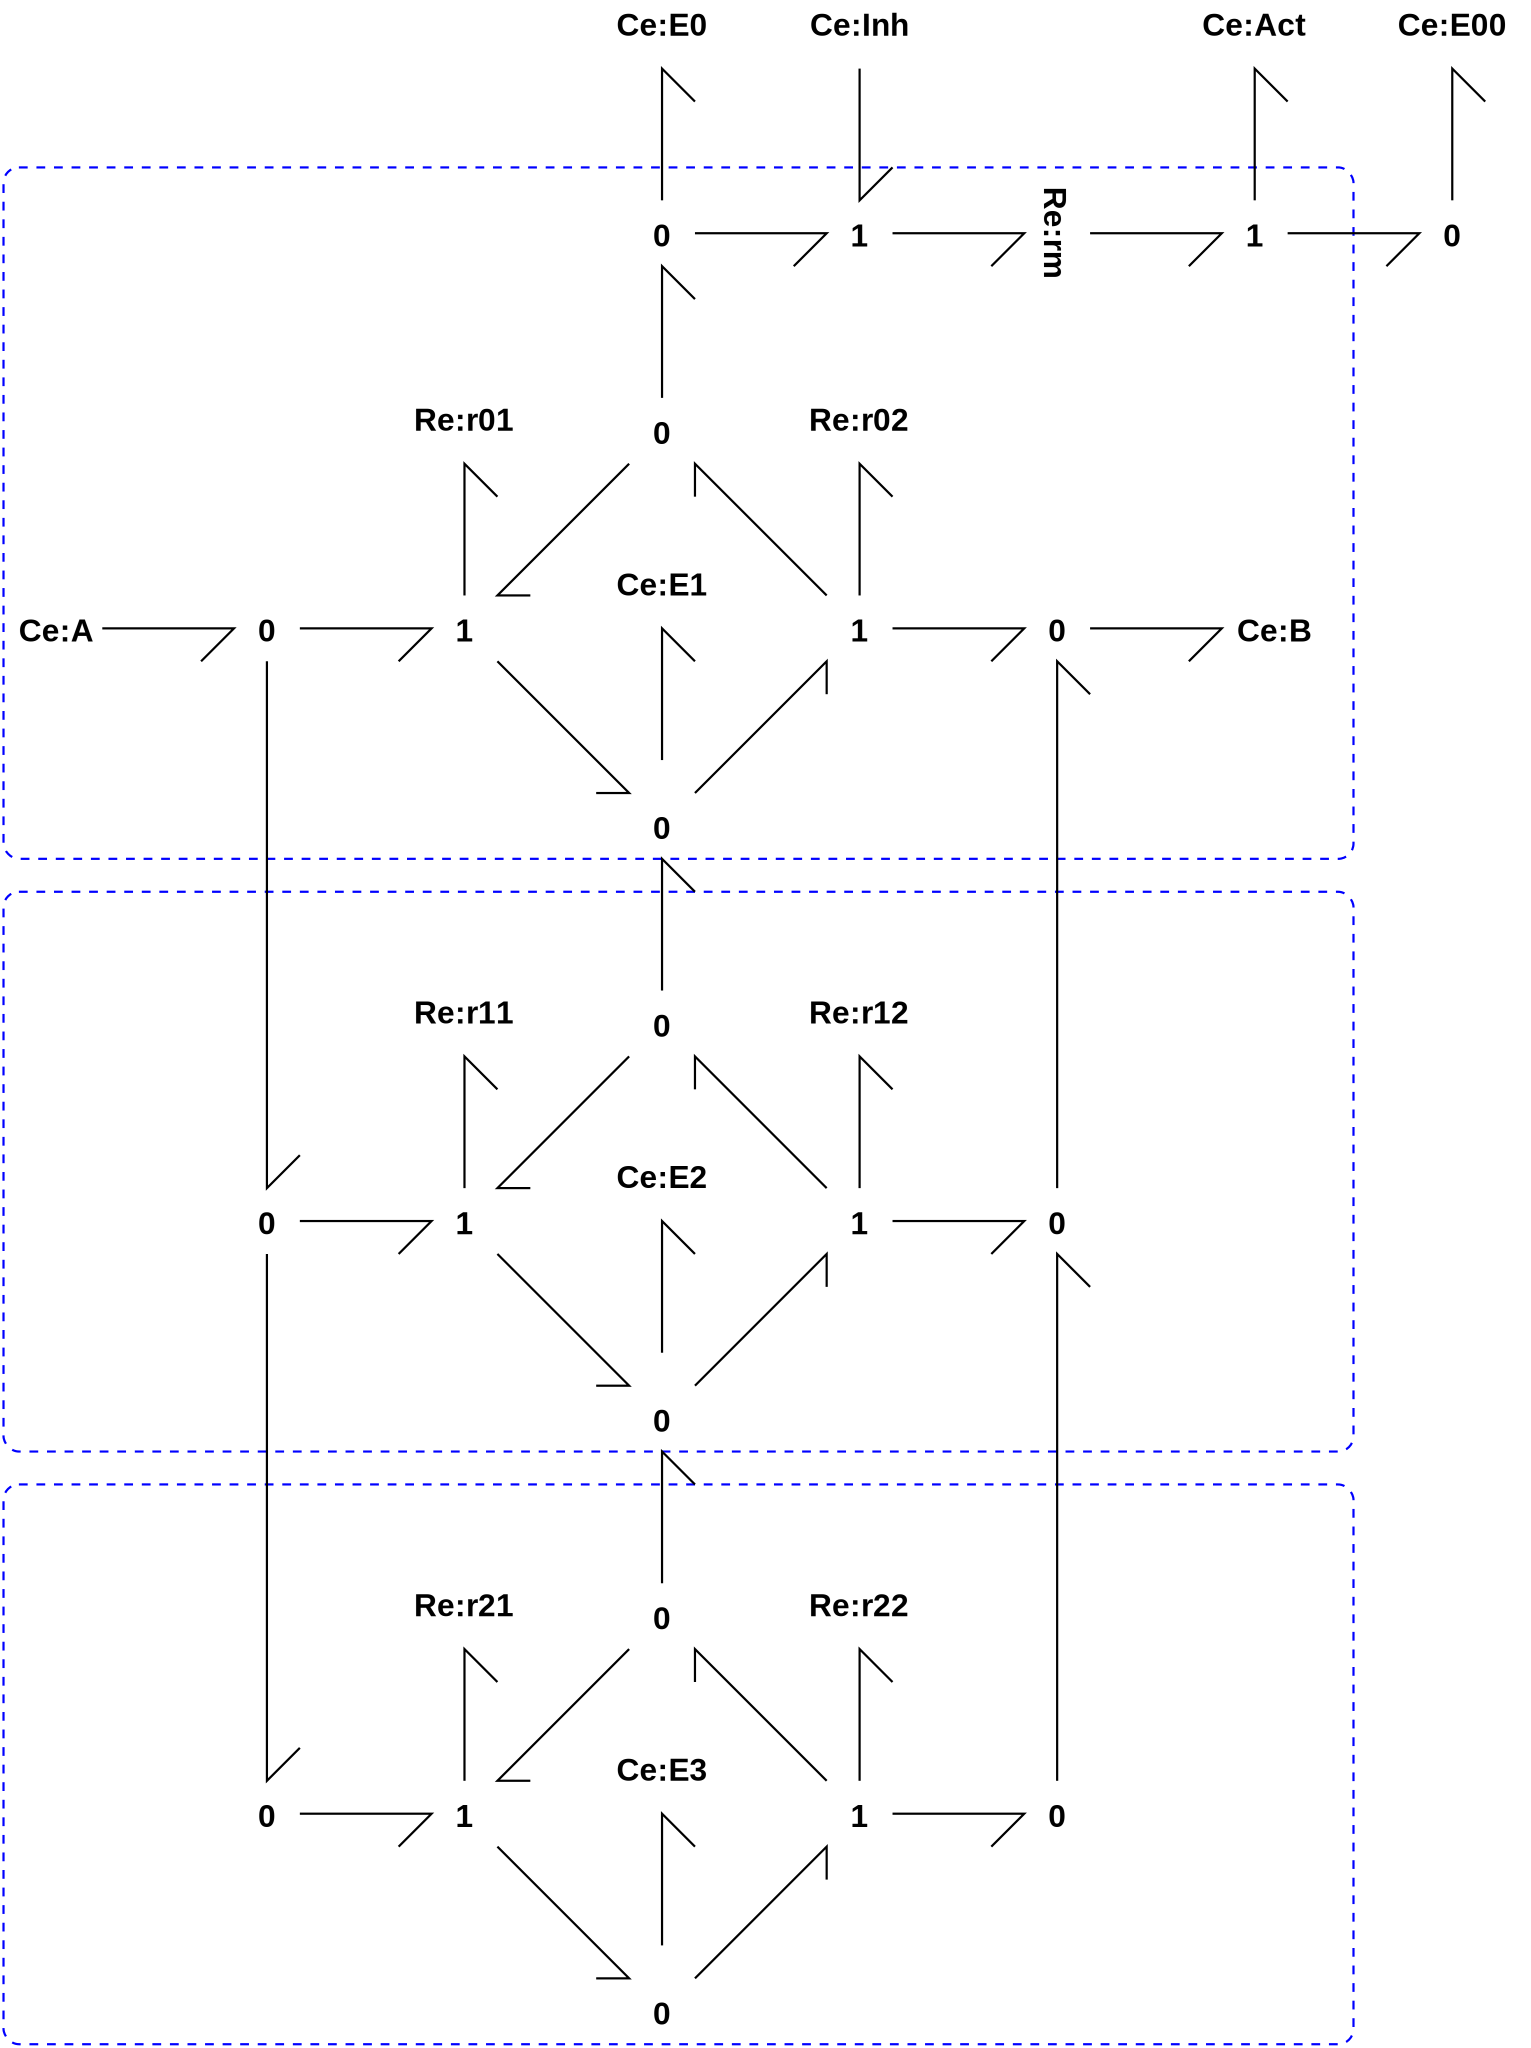

In [2]:
## Two-stage cooperative enzyme-catalysed reaction (N=2)
sbg.model('mCoop_abg.svg',quiet=quiet)
import mCoop_abg
disp.SVG('mCoop_abg.svg')

In [3]:
s = st.stoich(mCoop_abg.model(),quiet=quiet)
sc = st.statify(s,chemostats=['A','B','Act','Inh'])
disp.Latex(st.sprintrl(s,chemformula=True))


<IPython.core.display.Latex object>

#  Cyclic Flow Modulation (CFM)
As discussed in the context of the PFK/FBP cycle in the introduction, CFM involves a cycle formed of two modulated enzyme-catalysed reactions. Such a cycle is shown in the following bond graph with the following components and interpretation:

- mCoop:Fwd an instance of the mECR representing the forward reaction [PFK]
- mCoop:Rev an instance of the mECR representing the reverse reaction [FBP]
- Ce:A The substrate species [\ch{F6P}]
- Ce:B The product species [\ch{F16P}]
- Ce:Act The activation species [\ch{AMP + F26P}]
- Ce:Inh The inhibition species [\ch{ATP + Cit}]
- Ce:AAf,Ce:BBf,Ce:AAr,Ce:BBr Additional species [\ch{ATP},\ch{ADP},\ch{Pi},\ch{H2O}]

Note that the activator Ce:Act activates mCoop:Fwd and inhibits mCoop:Rev and Ce:Inh inhibits mCoop:Fwd and activates mCoop:Rev.

Creating subsystem: mCoop:Fwd
Creating subsystem: mCoop:Rev


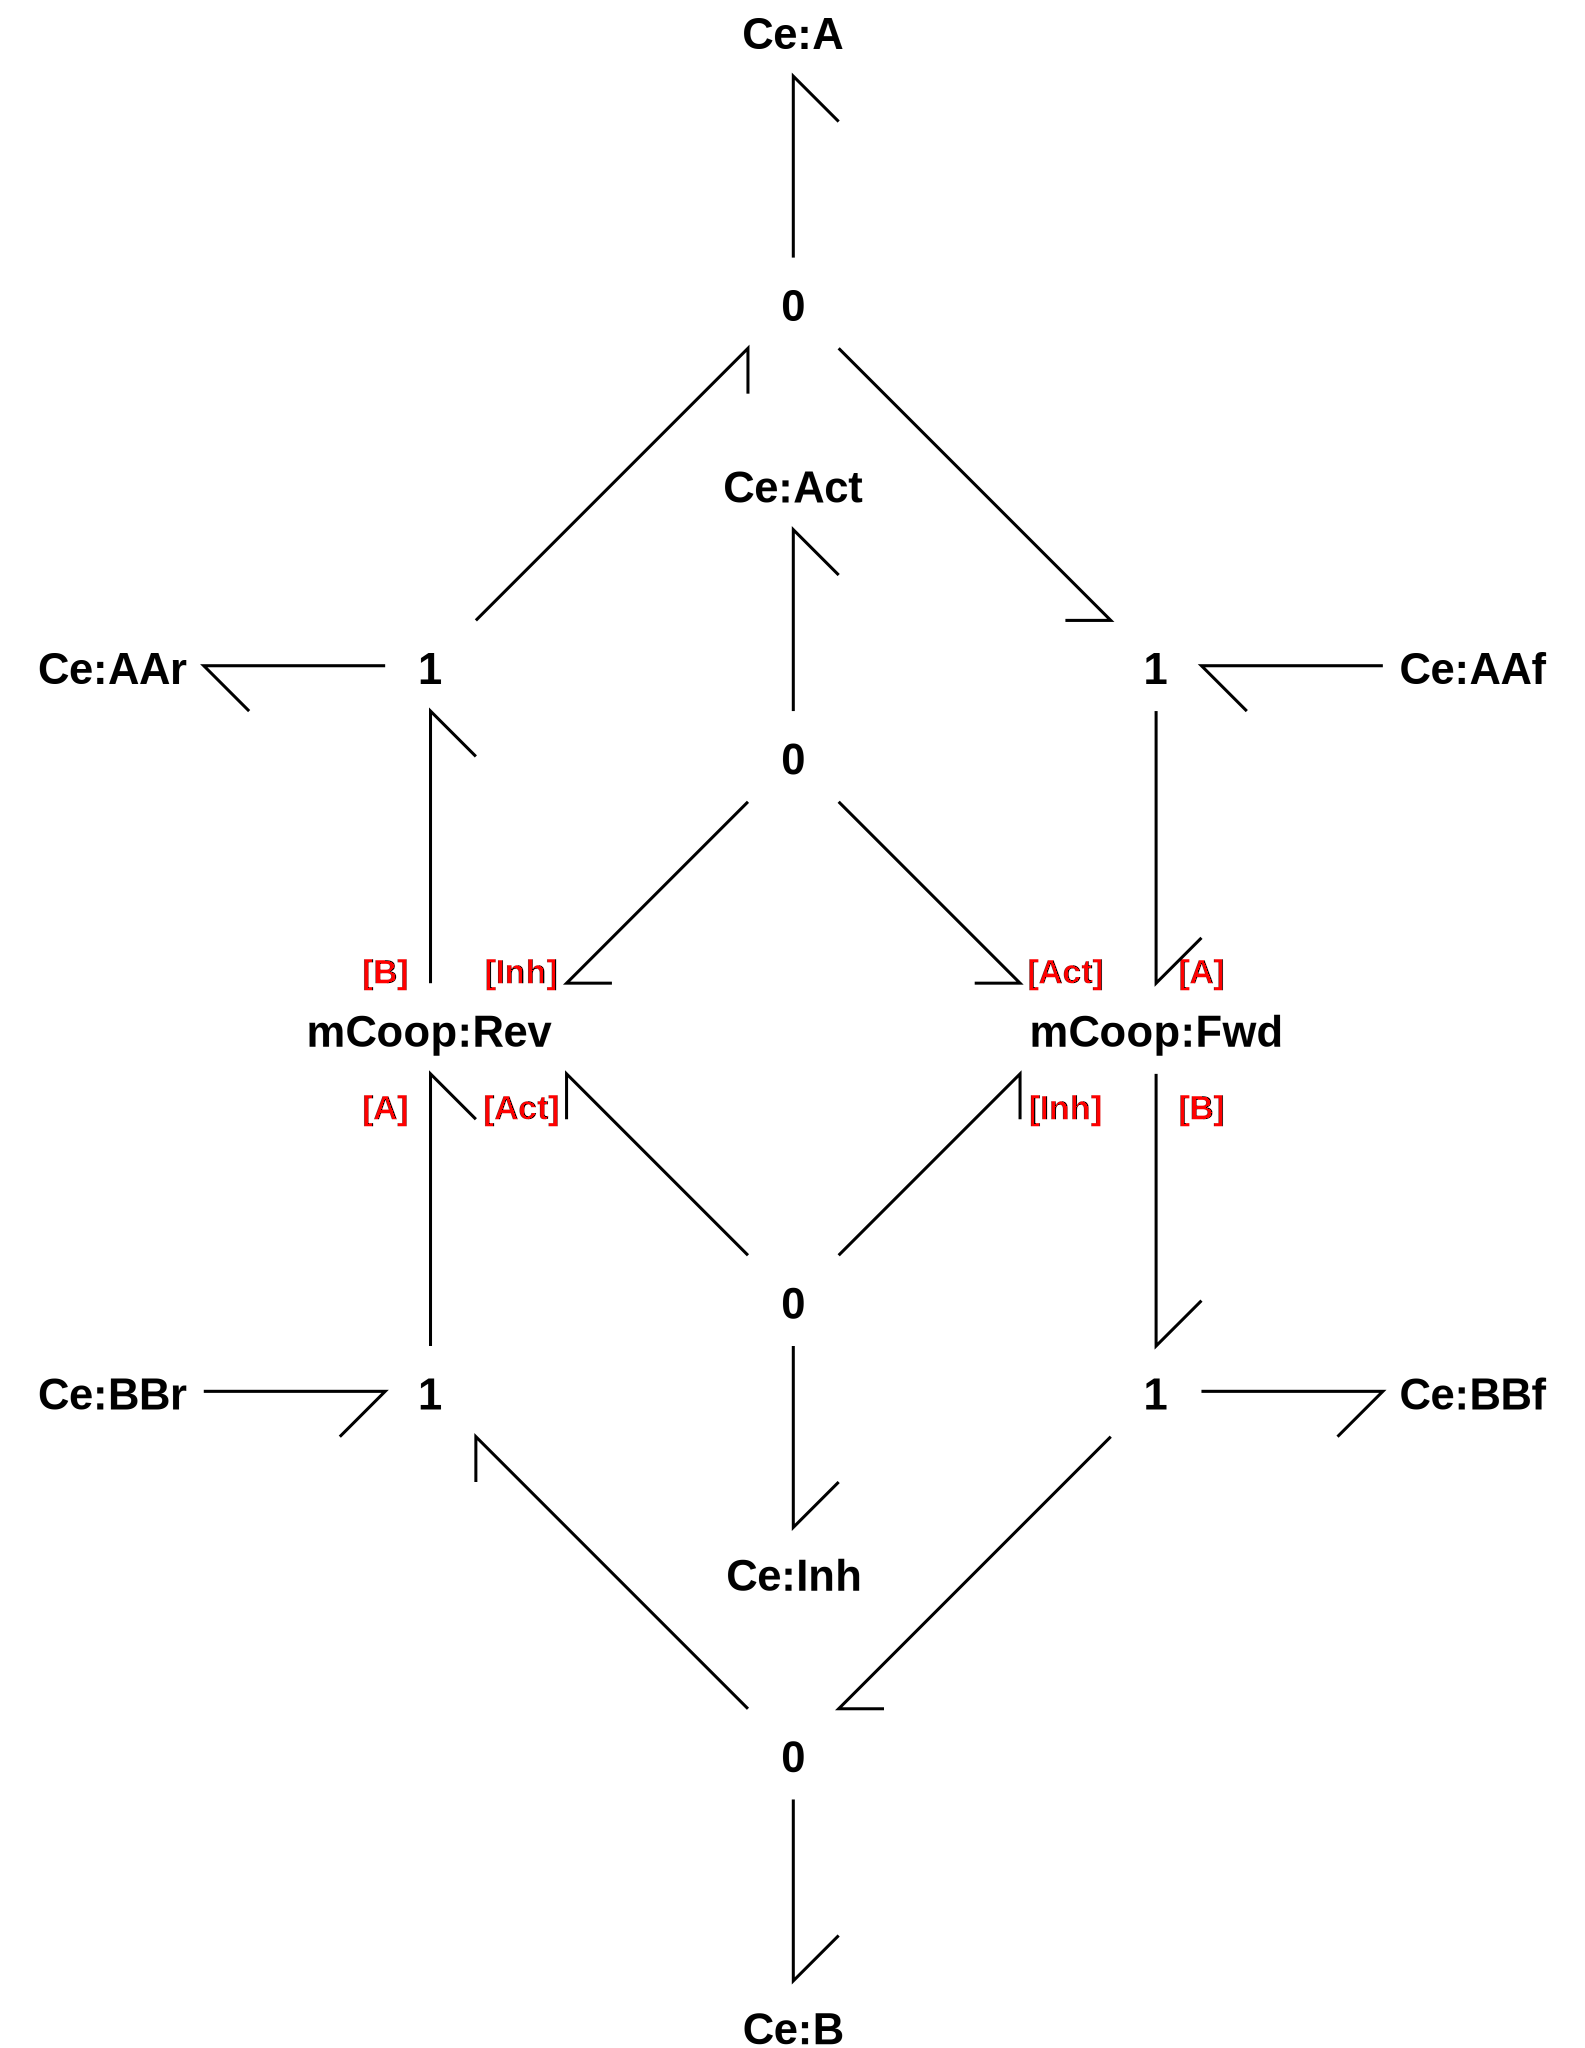

In [4]:
sbg.model('CFM_abg.svg',quiet=quiet)
import CFM_abg
imp.reload(CFM_abg)
disp.SVG('CFM_abg.svg')

## Stoichiometry and reactions

In [5]:
s = st.stoich(CFM_abg.model(),quiet=quiet)
sc = st.statify(s,chemostats=['A','B','Act','Inh','AAf','BBf','AAr','BBr'])
disp.Latex(st.sprintrl(s,chemformula=True))


<IPython.core.display.Latex object>

# Simulation of Steady-state properties

The steady state properties are investigated using dynamic simulation where slowly varing exogenous quantities are used to induce quasi-steady-state behaviour. In each case, the variable is at a constant value to start with followed by a slowly increasing ramp. The response after the initial reponse is plotted to remove artefacts due to the initial transient.

All parameters are unity except for $K_B=10^{-6}$ (to approximate an irreversible reaction) and initial states are chosen so that the total enzyme is $e_0=1$.

## Set up some parameters for simulation

In [6]:
## Set up some parameters for simulation
def setParameter(s,N,e0,K_0=1):
    ## Set up the non-unit parameters and states
    
    parameter = {}
    
    ## Cycle driving potentials
    K_BB = 1e-4
    parameter['K_BBf'] = K_BB
    parameter['K_AAr'] = K_BB
    
    kappa = 2
    X0 = np.ones(s['n_X'])
    for fr in ['Fwd','Rev']:
        K_i = 1/(K_0**(N+1))
        X0[s['spec_index'][fr+'_E00']] = (e0/(N+3))
        for i in range(N+2):
            Ei = '_E'+str(i)
            X0[s['spec_index'][fr+Ei]] = (e0/(N+3))
            Ki = 'K_'+fr+Ei
            parameter[Ki] = K_i
            K_i *= K_0
            if i<N+1:
                kappa_i = 'kappa_'+fr+'_r'+str(i)
                parameter[kappa_i+'1'] = kappa
                parameter[kappa_i+'2'] = kappa
                
    return parameter,X0

## Simulation code
The flow $v$ is a dynamical function of substrate $x_A$, activation $x_{Act}$, inhibition $x_{Inh}$ and cooperativity index $N$. An approximate steady-state is acjieved by varying one of the three concentrations slowly whilst fixing the other two. The following function does this by declaring the varying function species by the string sX, a fixed species with a number of discrete values as sX1 with values XX1 and the other species as sX2 with value X2.
N can take on a range of values.

deriv=True gives a plot of the derivative of the flow with respect to $\log_{10} X$.

In [7]:
def label(sX1,sX2,X1,X2,N,Loop=False):
    if N<0:
        return f'{sX1}={X1}, N={-N} (graphical)'
    else:
        if Loop:
            return f'{sX1}={X1}(Loop flow)'
        else:
            return f'{sX1}={X1}'

def VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[0.1,1,10],X2=1,NN=[2],K_B=1e-6,deriv=False,quiet=True):

    ## Time
    t_max = int(1e4)
    t = np.linspace(0,t_max,100000)
    t_0 = 100
    t_1 = t_max-t_0
    i_max = len(t)
    i_0 = int(i_max*t_0/t_max)
    i_1 = i_max-i_0

    
    ## Set up the chemostats: vary X
    x_max = 1e2
    x_min = 1e-2
    chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
    X_chemo =  {sX:chemo}
    
    for N in NN:
        for X1 in XX1:
            
            ## Non-unit parameters and states
            e0 = 1 # Total enzyme
            parameter,X0 = setParameter(s,abs(N),e0,K_0=1)
            X0[s['spec_index'][sX1]] = X1
            X0[s['spec_index'][sX2]] = X2
            #print(X0)
            dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)
            
            ## Extract flows at the chemostatted species
            VV = dat['V']
            dX  = s['N']@(VV.T)
            dX_B = dX[s['spec_index']['B'],:]
            dX_BBf = dX[s['spec_index']['BBf'],:]
            dX_AAr = dX[s['spec_index']['AAr'],:]
            V = dX_B
            V_C_1 = dX_BBf-V
            V_C = dX_AAr
            
            ## Extract the state being varied
            X = dat['X'][:,s['spec_index'][sX]]
        
            
            lw = 2
            ls = None
            if deriv:
                slope = np.gradient(V[-i_1:],np.log10(X[-i_1:]))
                plt.semilogx(X[-i_1:],slope,lw=lw,label=label(sX1,sX2,X1,X2,N),linestyle=ls)
                ylabel = '$dv/d \log_{10}{x}$'
                             
            else:
                p = plt.semilogx(X[-i_1:],V[-i_1:],lw=lw,label=label(sX1,sX2,X1,X2,N),linestyle=ls)
                colour = p[0].get_color()
                plt.semilogx(X[-i_1:],V_C[-i_1:],color=colour,lw=lw,linestyle='dotted')
                ylabel = '$v$'
 

    
    plt.xlabel('$x_{'+sX+'}$')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    #plt.title('N = '+str(N))
    plt.show()
  
    return dat,X

## Vary the substrate concentration.

 The substrate concentration $x_A$ is varied for two values of activation $x_{Act}$.
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
 

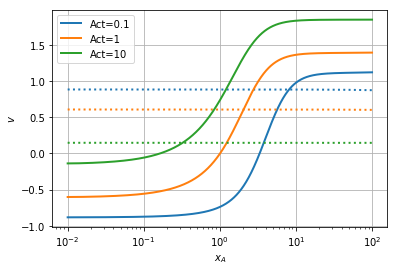

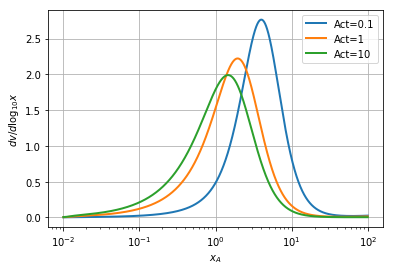

In [8]:
Act = [0.1,1,10]
dat,x = VaryX(sX='A',sX1='Act',sX2='Inh',XX1=Act,X2=1)
dat,x = VaryX(sX='A',sX1='Act',sX2='Inh',XX1=Act,X2=1,deriv=True)

## Vary the activation species concentration.

 The activation species concentration $x_{Act}$ is varied for three values of $x_{Inh}$. 
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
 

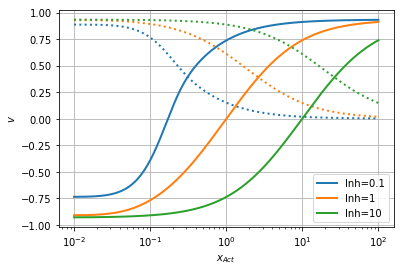

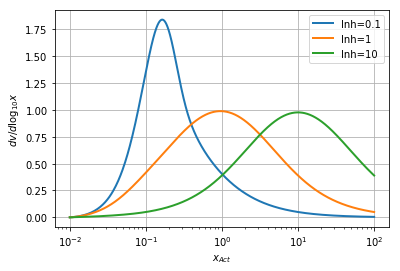

In [9]:
Inh = [0.1,1,10]
dat,x = VaryX(sX='Act',sX1='Inh',sX2='A',XX1=Inh,X2=1)
dat,x = VaryX(sX='Act',sX1='Inh',sX2='A',XX1=Inh,X2=1,deriv=True)

## Vary the substrate concentration.

 The substrate concentration $x_A$ is varied for three values of inhibition $x_{Inh}$.
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
  

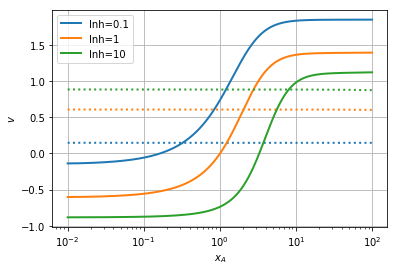

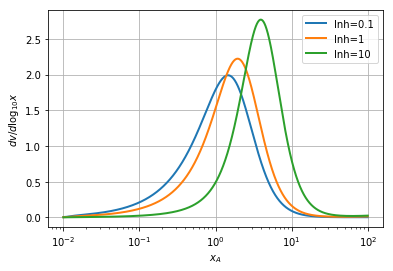

In [10]:
dat,x = VaryX(sX='A',sX1='Inh',sX2='Act',XX1=Inh,X2=1)
dat,x = VaryX(sX='A',sX1='Inh',sX2='Act',XX1=Inh,X2=1,deriv=True)

## Vary the inhibition species concentration.

 The inhibition species concentration $x_{Inh}$ is varied for two values of $N$.
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
  

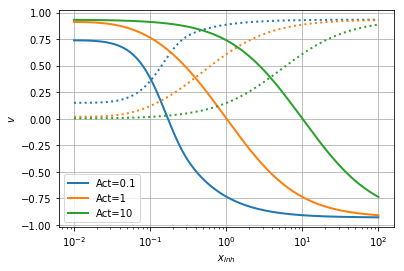

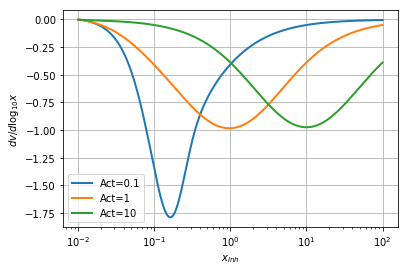

In [11]:
dat,x = VaryX(sX='Inh',sX1='Act',sX2='A',XX1=Act,X2=1)
dat,x = VaryX(sX='Inh',sX1='Act',sX2='A',XX1=Act,X2=1,deriv=True)

# Discussion

- Both positive and negative flow rates are possible
- The substrate concentration affects net flow but not loop flow.
- Loop flow is affected by the degree of activation/inhibition as well as the driving species AAf, BBf, AAr and BBr.
- Note that species A potential $\phi_A = \ln K_AX_A$. Thus plotting against $\log_{10} X$ is equivalent to     plotting against potential with a constant factor.
- Increasing activation increases flow - this corresponds to positive feedback with positive incremental gain given by the derivative plots.
- Increasing inhibition decreases flow - this corresponds to negative feedback with negative incremental gain given by the derivative plots.
- the behaviour is dependent on the parameters of the particular enzyme-catalysed reaction; those used here are for illustration.

## Fructose-2,6-phosphate (\ch{F26P}) 
The reaction 
\ch{F6P + ATP <>[PFK2] F26P + ADP}
is catalysed by the enzyme PFK2 where

- \ch{PFK2} phosphofructokinase-2
- \ch{F6P} fructose-6-phosphate
- \ch{F26P} fructose-2,6-biphosphate

As pointed out by 
<cite data-cite="GarGri17">Garret and Grisham (2017)</cite> section 22.2a,
the PFK2-catalysed reaction forms a cycle with the reaction:
\ch{F26P + H2O <>[F26BP] F6P + Pi}
where:

- \ch{F26BP} fructose-2,6-biphosphatase
- \ch{Pi} inorganic phosphate

The species which activate PFK2 and inhibit F26BP include:

- \ch{AMP}
- \ch{F6P} fructose-6-phosphate

Thus this pair of reactions is a further example of Cyclic Flow Modulation (CFM).

Moreover, the PFK and PFK2 CFMs stongly interact:

- The PFK CFM is positively modulated by the product of the PFK2 CFM: \ch{F26P} 
- the PFK2 CFM is positively modulated by the substrate of the PKF (and PFK2) CFM: \ch{F6P}
- both are positively modulated by \ch{AMP}.
- this has been sugested as a mechanism for **integral action** <cite data-cite="CloWel10">Cloutier and Wellstead (2010).

TIGAR (TP53-induced gycolysis and apoptosis regulator) mimics \ch{F26P}; this is related to oncogenesis
<cite data-cite="GarGri17">Garret and Grisham (2017).